For installing torchsummary use `pip install torchsummary`

In [217]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [218]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [219]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [220]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

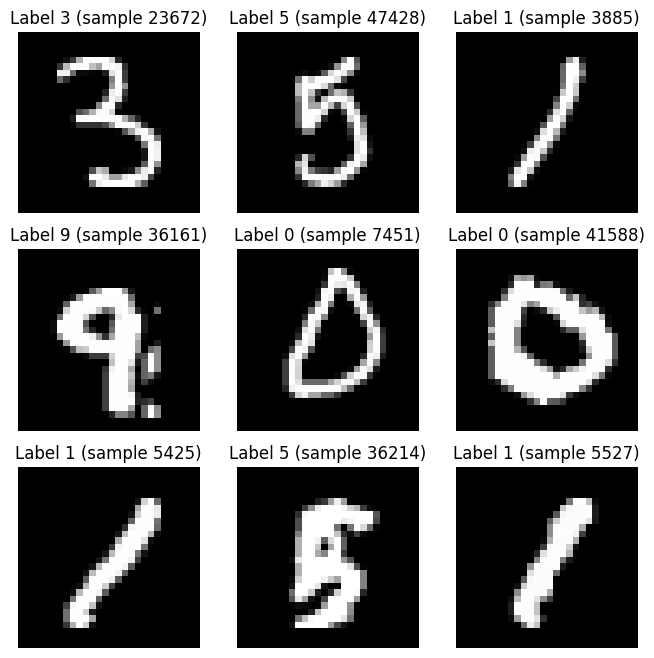

In [221]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [222]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [223]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


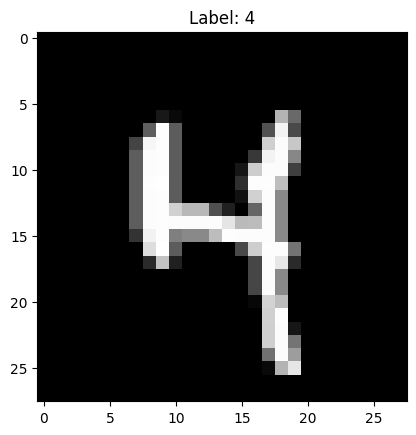

In [224]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [225]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    N = x.shape[0] # batch size
    x1 = x.view(N, -1) #flatten image
    return x1@W.T+b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    s = torch.exp(z)
    return s/torch.sum(s, dim=1).reshape(-1,1)
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x,W,b))
    # YOUR CODE (END)


##### TEST

In [226]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape, b.shape)
u = predict(X,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([64, 10]) 64.0


#### Loss Function

In [227]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    N = y.shape[0]
    return -torch.log(uhat[torch.arange(N), y[:]])
    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y, uhat))
    # YOUR CODE (END)


##### TEST

In [228]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [229]:
def grad_loss_ce(X,u,uhat):
    """
    X -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    grad_W = torch.mean((uhat-u).view(-1,10,1)*X.view(-1,1,28*28), dim=0)
    grad_b = torch.mean((uhat-u), dim=0)
    return grad_W, grad_b   
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [230]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)    
    uhat = predict(X,W,b)
    pred_class = torch.argmax(uhat, dim=1)
    cost = cost_ce(Y, uhat)
    acc  = (pred_class == Y).sum() / len(Y)
    return cost, acc
    
    # YOUR CODE (END)

#### Training

In [232]:
nepochs = 10
alpha = 0.1
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
n_samples = len(train_dataloader)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    cost_test = 0.0
    acc = 0
    acc_test = 0.0
    
    for X,Y in train_dataloader:
        # X.shape = [64, 1, 28, 28], Y.shape = [64], W.shape = [10, 784], b.shape = [1, 10]
        uhat = predict(x=X, W=W, b=b)
        # uhat.shape = [1, 10]
        u = (Y.view(-1,1) == torch.arange(nclasses).view(1, nclasses)).float()
        # u.shape = [64, 10]
        
        # Gradients
        grad_W, grad_b = grad_loss_ce(X=X, u=u, uhat=uhat)
        W = W - alpha * grad_W
        b = b - alpha * grad_b
        
        # Get metrics for batch
        batch_cost_train, batch_acc_train = metrics(X=X, Y=Y, W=W, b=b)
        
        # Update metrics
        cost += batch_cost_train.item()
        acc += batch_acc_train.item()
    
    # Test accuracy
    cost_test, acc_test = metrics(X=Xtest, Y=Ytest, W=W, b=b)
    
    # Divide metrics according to mini-Batch Size
    cost = cost / n_samples
    acc = acc / n_samples
    
    # Append metrics of epoch
    cost_hist.append(cost)
    acc_hist.append(acc)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)
        
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 1.959286, 0.669010, 0.927956, 0.808400
Epoch 1: 0.829002, 0.824710, 0.713863, 0.844300
Epoch 2: 0.675651, 0.851562, 0.628572, 0.860200
Epoch 3: 0.598111, 0.864872, 0.575658, 0.871600
Epoch 4: 0.548084, 0.873534, 0.540952, 0.875600
Epoch 5: 0.512125, 0.879747, 0.518351, 0.880800
Epoch 6: 0.484974, 0.884062, 0.495648, 0.884000
Epoch 7: 0.463349, 0.888076, 0.483470, 0.887500
Epoch 8: 0.445156, 0.890708, 0.462968, 0.889700
Epoch 9: 0.430410, 0.893990, 0.450564, 0.892600
3.6167627


Text(0.5, 1.0, 'Accuracy')

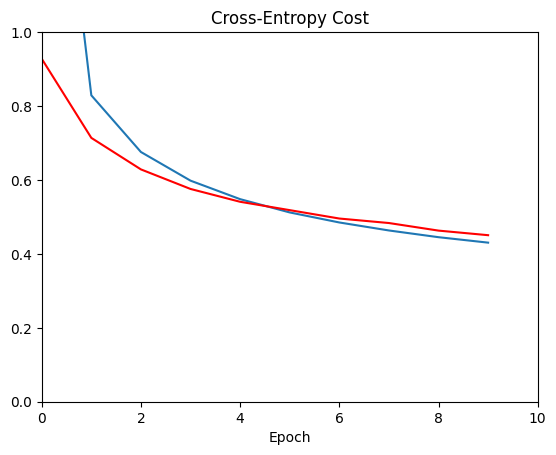

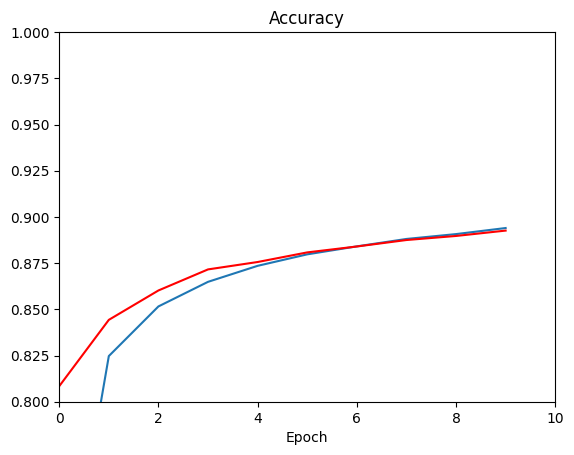

In [233]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

> Even though in the exercise it is said to use LR = 0.01 and n_epochs = 10 we used LR = 0.1  because the plots below hardly make sense as it only reaches 80% accuracy within the 10 epochs with the given learning rate.

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

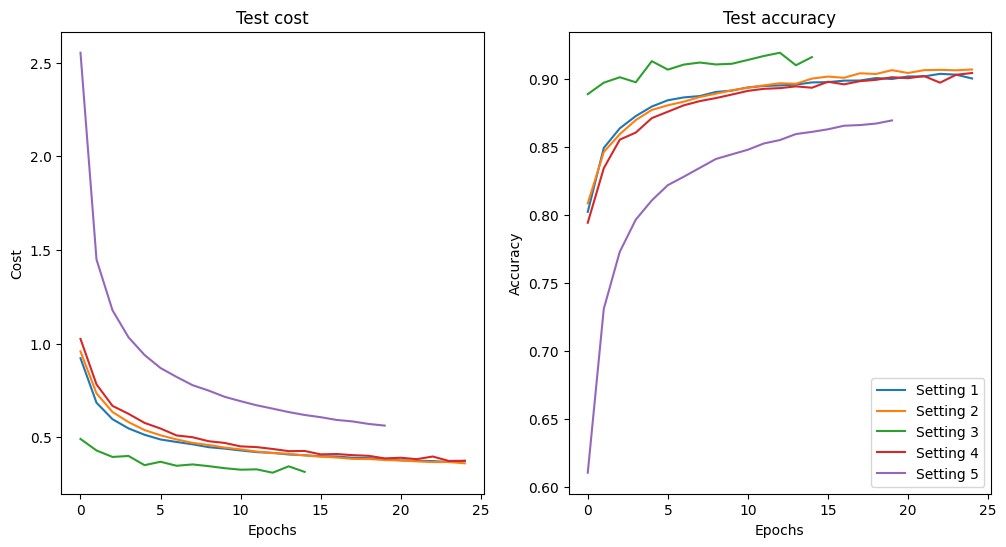

In [235]:
# THIS TAKES A WHILE TO EXECUTE!!
def do_train(alpha, nepochs, batch_size):

    nclasses = 10
    nbatch = batch_size

    cost_hist = []
    acc_hist = []
    cost_hist_test = []
    acc_hist_test = []

    # data loader
    train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    n_samples = len(train_dataloader)

    # test data - we can load all samples for the test since it easily fits into memory
    Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

    # initial parameters
    W,b = torch.randn((10,28*28)), torch.zeros((1,10))    
    
    for epoch in range(nepochs):
        #cost = 0.0
        cost_test = 0.0
        #acc = 0
        acc_test = 0.0

        for X,Y in train_dataloader:
            # X.shape = [64, 1, 28, 28], Y.shape = [64], W.shape = [10, 784], b.shape = [1, 10]
            uhat = predict(x=X, W=W, b=b)
            # uhat.shape = [1, 10]
            u = (Y.view(-1,1) == torch.arange(nclasses).view(1, nclasses)).float()
            # u.shape = [64, 10]

            # Gradients
            grad_W, grad_b = grad_loss_ce(X=X, u=u, uhat=uhat)
            W = W - alpha * grad_W
            b = b - alpha * grad_b
        
        # Test accuracy
        cost_test, acc_test = metrics(X=Xtest, Y=Ytest, W=W, b=b)            

        # Append metrics of epoch
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
    
    return cost_hist_test, acc_hist_test

models = {
    "Setting 1": {"learning_rate": 0.1, "epochs": 25, "batch_size": 64},
    "Setting 2": {"learning_rate": 0.2, "epochs": 25, "batch_size": 128},
    "Setting 3": {"learning_rate": 0.4, "epochs": 15, "batch_size": 32},
    "Setting 4": {"learning_rate": 1.5, "epochs": 25, "batch_size": 1028},
    "Setting 5": {"learning_rate": 2, "epochs": 20, "batch_size": 5140}
}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for key in models:
    model = models[key]
    learning_rate = model["learning_rate"]
    epochs = model["epochs"]
    batch_size = model["batch_size"]
    cost, acc = do_train(alpha=learning_rate, nepochs=epochs, batch_size=batch_size)
    ax[0].plot(np.arange(len(cost)), cost, label=key)
    ax[1].plot(np.arange(len(acc)), acc, label=key)

ax[0].set_title("Test cost")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Cost")
ax[1].set_title("Test accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.legend()
plt.show()

### 5. With Full-Fledge PyTorch

In [236]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28, 10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [237]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [238]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [239]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

model = NeuralNetwork()
cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        
        pred = model(X)
        loss = cost_ce(pred, Y)
        
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    cost /= nbatches
    acc /= size
    
    cost_test = 0.0
    acc_test = 0.0
    with torch.no_grad():
        for X, Y in test_loader:
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost_test += loss.item()
            pred_class = torch.argmax(pred, dim=1)
            acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

    cost_test /= len(test_loader)
    acc_test  /= len(test_loader.dataset)   
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)

Epoch 0: 0.977646, 0.807583, 0.599637, 0.869800
Epoch 1: 0.550767, 0.868267, 0.475445, 0.884300
Epoch 2: 0.471506, 0.880283, 0.425884, 0.892000
Epoch 3: 0.432820, 0.886667, 0.398192, 0.894400
Epoch 4: 0.408972, 0.890800, 0.379138, 0.899100
Epoch 5: 0.392021, 0.894800, 0.365045, 0.902200
Epoch 6: 0.379440, 0.897333, 0.354635, 0.905800
Epoch 7: 0.369428, 0.899383, 0.346612, 0.906700
Epoch 8: 0.361339, 0.901233, 0.339877, 0.908400
Epoch 9: 0.354639, 0.902883, 0.334500, 0.910200


Text(0.5, 1.0, 'Accuracy')

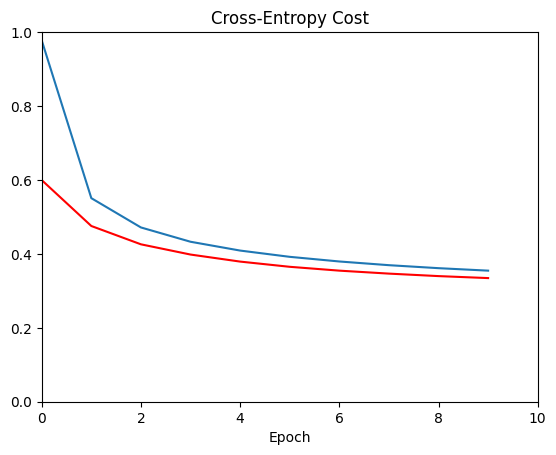

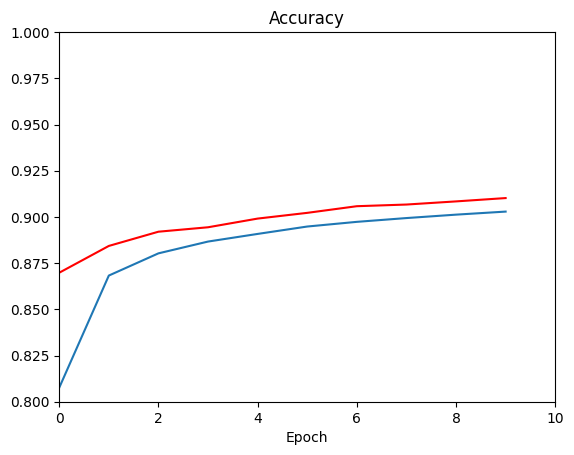

In [240]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")